In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace
import math

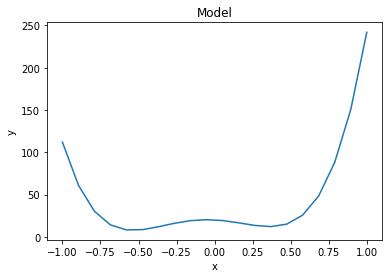

In [24]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [20,-10,-93,75,250]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=-1, stop=1, num=20)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

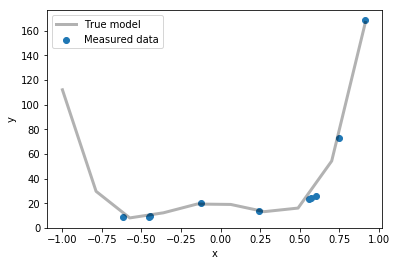

In [45]:
# Hyperparameters for the type of noise-generating distribution.
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 10         # number of samples

np.random.seed(1234)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)

# Generate noisez

pdf = laplace.pdf

normVariance = 1 # Input as the scale parameter in the normal distribution

laplaceVariance = 1

alfa = 0

gamma = 0.1

noiseNorm = magnitude * np.random.normal(loc, normVariance, int(alfa * N))

noiseLaplace = magnitude * np.random.laplace(loc, laplaceVariance, int((1-alfa)*N))
y = y_true + noiseLaplace


plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(-1, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

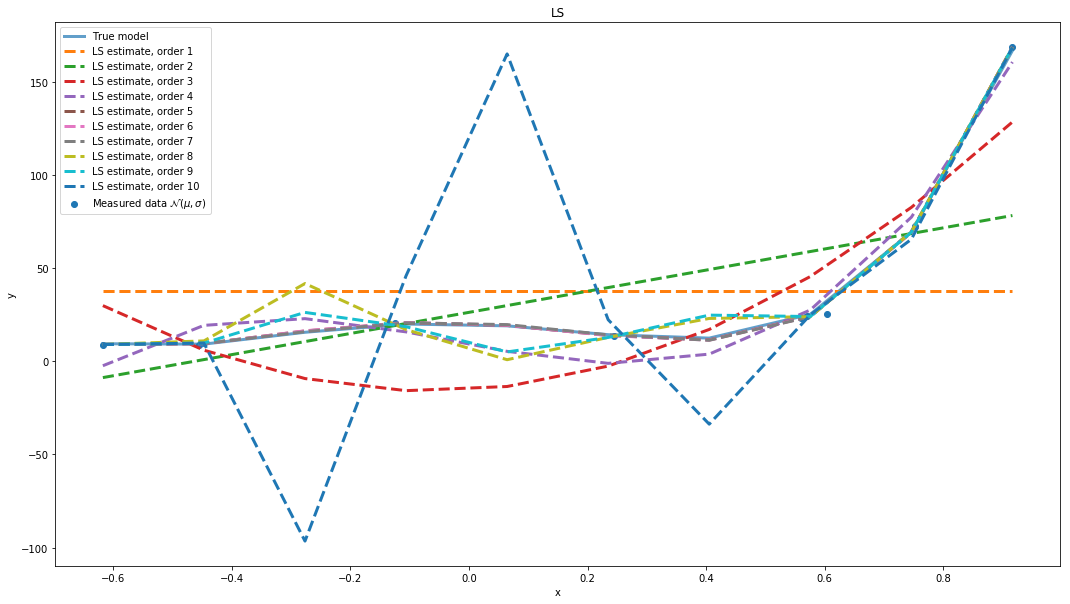

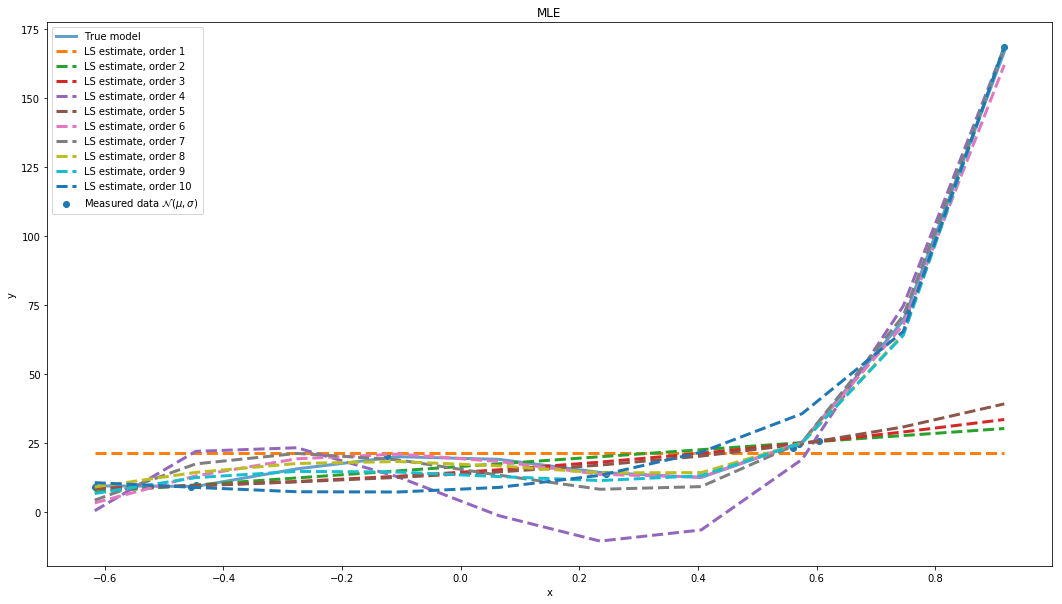

In [60]:
# Matrix form
def LSorderFunc(order, u, y, N):
    u_tensor_0 = np.reshape(u,(N,1))
    #print(u_tensor_0)
    ones_vec = np.ones((N,1))

    u_tensor = ones_vec
    #print(ones_vec)

    #print(u_tensor)

    for i in range(1,order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    #print(u_tensor1)

    #-------------
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse

    u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product


    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
    LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
    #print(f"LS parameters:         {LS_params_rounded}")
   # print(f"True model parameters: {true_params}")

    #diffParams = []
    #for i in range(0, order):
    #    diffParams.append(float(true_params[i] - float(LS_params_rounded[i])))

    #print("The differnence between the estimated theata and the real Theta is: " )
    #print(diffParams)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    LS_estimate = arbitrary_poly(LS_params)
    return LS_params, LS_estimate

def log_lik(par_vec, y, x):
      # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

def MLEfunction(order,u, y, N):

    import scipy.optimize as optimize

    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(order+1)
    init_guess[-1] = N

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                options={'disp': False},
                                args = (y, u))

    MLE_params = opt_res.x[:-1]
    MLE_estimate = arbitrary_poly(MLE_params)

    MLE_params_rounded = ["{:.2f}".format(round(i, 2)) for i in MLE_params.tolist()]
    #print(f"\nMLE parameters of order :      {MLE_params_rounded}")

    return MLE_params, MLE_estimate

    

def plotSeveral(orderArray):
    plt.figure(1, figsize=(18,10))
    plt.scatter(u, y,  label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
    u0 = np.linspace(min(u), max(u), N)
    plt.plot(u0, y_model(u0), alpha=0.7, lw=3, label="True model")
    
    for i in orderArray:
        LS_params, LS_estimate = LSorderFunc(i, u, y, N)
        plt.plot(u0, LS_estimate(u0),linestyle="--",  lw=3, label=r"LS estimate, order " f"{i}")
    plt.title("LS")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y");
    
    plt.figure(2, figsize=(18,10))
    plt.scatter(u, y,  label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
    u0 = np.linspace(min(u), max(u), N)
    plt.plot(u0, y_model(u0), alpha=0.7, lw=3, label="True model")
    
    for i in orderArray:
        MLE_params, MLE_estimate = MLEfunction(i, u, y, N)
        plt.plot(u0, MLE_estimate(u0),linestyle="--",  lw=3, label=r"LS estimate, order " f"{i}")
    
    plt.title("MLE")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y");
    
    
plotSeveral([1,2,3,4,5,6,7,8,9,10])

#LS_params_1, LS_estimate_1 = LSorderFunc(1, u, y, N)
#LS_params_2, LS_estimate_2 = LSorderFunc(2, u, y, N)
#LS_params_3, LS_estimate_3 = LSorderFunc(3, u, y, N)
#print(LS_params_1, LS_params_2, LS_params_3)
# Plot true vs. estimated model

#plt.scatter(u, y,  label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
#u0 = np.linspace(min(u), max(u), N)
#plt.plot(u0, y_model(u0), "g", alpha=0.7, lw=3, label="True model")
#plt.plot(u0, LS_estimate_1(u0), color="darkorange" ,linestyle="--",  lw=3, label="LS estimate, order 1")
#plt.plot(u0, LS_estimate_2(u0), color="black" ,linestyle="--",  lw=3, label="LS estimate, order 2")

#plt.plot(u0, LS_estimate_3(u0), "r--",  lw=3, label="LS estimate, order 3")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");